<a href="https://colab.research.google.com/github/its-discreeeet/Customer-Review-Sentiment-Analysis/blob/main/bdt_miniproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Customer Sentimental Analysis using Spark and Python on Google Colab

## Project Setup

We can use this information to analyze Amazon’s most successful jewellery product launches, discover insights into consumer reviews and personal favourites and assist with ML models.

In order to start any big data computations or analysis, we need to install the necessary components for Google Colaboratory, decompress them and install modules for our IDE.  


We aim to use Python to code our Spark programs, but because Spark setup is mainly set up on Scala, we need to use the JDK for Java to set up the Java VM.

In [7]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar -xvf spark-3.5.3-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

spark-3.5.3-bin-hadoop3/
spark-3.5.3-bin-hadoop3/data/
spark-3.5.3-bin-hadoop3/data/graphx/
spark-3.5.3-bin-hadoop3/data/graphx/users.txt
spark-3.5.3-bin-hadoop3/data/graphx/followers.txt
spark-3.5.3-bin-hadoop3/data/mllib/
spark-3.5.3-bin-hadoop3/data/mllib/sample_linear_regression_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_fpgrowth.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_libsvm_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/gmm_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/kmeans_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/streaming_kmeans_data_test.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_lda_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_multiclass_classification_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/pagerank_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_isotonic_regression_libsvm_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_lda_libsvm_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_movielens_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/pic_data

This installs all the necessary dependencies in Colab. Now, we can set the environment variables to point to this virtual machine and and use the downloaded Spark path. This will enable us to run Pyspark in the Colab environment.

In [10]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

We then locate Spark on the Drive.

In [11]:
import findspark
findspark.init()

Once Spark has been located, we can start a SparkSession with PySpark. A SparkSession is the entry point of an application and can handle operations in the scope of the application.  

In [12]:
# import from pyspark library
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

We use the spark.sql.shuffle.partitions to redistribute data across the RDD (a Spark database) frame.

In [13]:
spark = SparkSession \
    .builder \
    .appName("Spark Customer Review Analysis for Amazon") \
    .config("spark.sql.shuffle.partitions", "100")\
    .getOrCreate()

A Spark application called "Spark Review Analysis for Amazon" should be running on the server. Now, let's try loading the dataset. Our dataset is a structured file (.csv), which makes it easier to analyse large amounts of data as well. The dataset is stored on a shared Google Drive folder, but the file might need to be publicly accessible.  

In [14]:
import pandas as pd
import io

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset we are using is a .tsv file obtained from Amazon's Jewelry Review dataset on: https://www.kaggle.com/datasets/loorsawalhi/amazon-jewelry-reviews. Because this is a .tsv file instead of a .csv, we need to explicitly declare the separator to be a TAB space instead of a COMMA separator.  

In [21]:
#upload the Kaggle downloaded dataset
loaded_info = spark.read.csv('/content/drive/My Drive/amazon_reviews_us_Jewelry_v1_00.tsv', sep='\t', inferSchema=True, header=True)

The dataset should now be loaded. printSchema() should show the columns and their data types as a hierarchy arising from 'root'.

In [23]:
loaded_info.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)



---
---

## Dataset Analysis


Let's have a look at what the loaded dataset looks like as a table, and what values the columns have.

In [24]:
# show() is a function that displays the top 20 rows of a dataset
loaded_info.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   50423057|R135Q3VZ4DQN5N|B00JWXFDMG|     657335467|Everbling Purple ...|         Jewelry|          5|            0|          0|   N|                Y|           Beauties!|so beautiful even...| 2015-08-31|
|         US|   11262325|R2N0QQ6R4T7YRY|B00W5T1H9W|      26030170|925 Sterling Silv...|         Jewelry|          5|    

From the dataset, we can see that the review ID is unique in the table. This is the primary key. The customer ID is unique to each customer submitting their review, and the product ID is unique to each product.  

## Exploratory Analysis





Getting a general overview on what reviews are like helps Amazon better understand what sort of product must be featured as a popular choice and what mustn't.

#### Total Reviews in Database

We assume that, for the scope of this project, every review has a star rating of 1 - 5. This means we would have to clean out records that are invalid (NULL, or other types).


In [25]:
import pyspark.sql.functions as F

# Taking invalid star ratings out of our dataset
loaded_info = loaded_info.filter(F.col("star_rating").cast("int").isNotNull())

ratings_df = loaded_info.groupBy("star_rating").count().withColumnRenamed("count","num_ratings")
ratings_df.show()

+-----------+-----------+
|star_rating|num_ratings|
+-----------+-----------+
|          3|     159728|
|          1|     155096|
|          5|    1081450|
|          4|     270571|
|          2|     100851|
+-----------+-----------+



We can plot the distribution of ratings from 1-5 using the pandas module in Python.

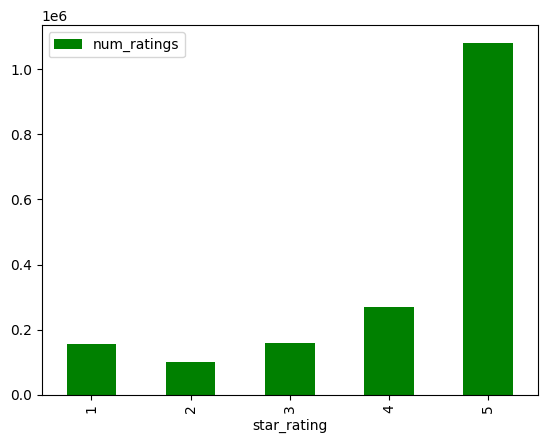

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

ratings_plot = pd.DataFrame(ratings_df.collect())
ratings_plot.columns = ['star_rating','num_ratings']
ratings_plot.sort_values(by=['star_rating'], inplace=True)

ratings_plot.plot(kind='bar',x='star_rating',y='num_ratings',color='green')
plt.show()


We can also find the number of records in this cleaned dataset to obtain the total number of reviews in the dataset.

In [27]:
# count the number of valid reviews in the dataset
print("There are %d reviews in the cleaned dataset." % loaded_info.count())

There are 1767696 reviews in the cleaned dataset.


#### Reviews Per Unique Product

The number of reviews per product can be obtained by creating a collection of records that fall under the same product IDs. The groupBy() function makes a collection. withColumnRenamed() takes in the column that needs to be changed, and changes it to the parameter inserted second.

In [28]:
# categorise reviews by the product's id (which is unique) and create a dataframe product_reviews
product_reviews = loaded_info.groupBy("product_id").count().withColumnRenamed("count","product_reviews")
product_reviews.show()

+----------+---------------+
|product_id|product_reviews|
+----------+---------------+
|B00SCVJBAY|             32|
|B00QRJMR8Q|              2|
|B00BQ7PO34|             28|
|B008BK2SCE|              1|
|B00DLZ0R2C|            536|
|B0119H2FEQ|              3|
|B0122U1X8S|              1|
|B00AC7WFXG|             44|
|B009W1R7AE|              2|
|B00Y9FTS46|              3|
|B00O8XR67U|              1|
|B002AQ3K36|             15|
|B004OUGJY8|              8|
|B00LKOD0HK|              1|
|B00B7KON8C|              2|
|B00BQQUW6E|              1|
|B007X2NVHC|              6|
|B00LKP6IQ4|              3|
|B002BA5O12|             57|
|B00DE9RTUI|              3|
+----------+---------------+
only showing top 20 rows



#### Number of Products

In [29]:
# count how many products there are
print("There are %d products in the cleaned database" % product_reviews.count())

There are 574080 products in the cleaned database


#### 5 Highest Reviewed Jewellery Products


We can use sort() to a dataframe to arrange the rows in a particular order. We want the highest records to be on top, so we use ascending=False. take(5) grabs the first 5 records as objects in a list. In order to display it as a table, we need to convert it back to a dataframe using spark.createDataFrame().

In [30]:
# from the dataframe, obtain the 5 highest reviewed products
top_products = product_reviews.sort("product_reviews",ascending=False).take(5)

# change the list back to dataframe
top_products = spark.createDataFrame(top_products)
top_products.show()

+----------+---------------+
|product_id|product_reviews|
+----------+---------------+
|B008XWDAUE|           2669|
|B004Q7AB4I|           1880|
|B005G13PRI|           1560|
|B0081IZ3UA|           1124|
|B007RD9DS8|           1106|
+----------+---------------+



#### Details of Highest Reviewed Product

In [31]:
top_products.join(loaded_info,"product_id","left").select("product_id","product_reviews","marketplace","product_title","product_category").show(1)

+----------+---------------+-----------+--------------------+----------------+
|product_id|product_reviews|marketplace|       product_title|product_category|
+----------+---------------+-----------+--------------------+----------------+
|B008XWDAUE|           2669|         US|BUYINHOUSE Vintag...|         Jewelry|
+----------+---------------+-----------+--------------------+----------------+
only showing top 1 row



#### Summary of Product Reviews

We use summary() to extract the largest number of products, which is in the field 'count', the mean product reviews, the standard deviation of reviews, and the median number of reviews in which is in the field '50%'.

In [32]:
product_reviews.select('product_reviews').summary().show()

+-------+------------------+
|summary|   product_reviews|
+-------+------------------+
|  count|            574080|
|   mean| 3.079180602006689|
| stddev|12.049018034977763|
|    min|                 1|
|    25%|                 1|
|    50%|                 1|
|    75%|                 2|
|    max|              2669|
+-------+------------------+



#### Number of Reviews Per Customer

In [33]:
# Create the consumer_table DataFrame
customer_reviews = loaded_info.groupBy('customer_id').count().withColumnRenamed("count", "customer_reviews").cache()
customer_reviews.show()

+-----------+----------------+
|customer_id|customer_reviews|
+-----------+----------------+
|   52535937|               3|
|   11294895|               3|
|   36338393|               1|
|   45657423|               1|
|   19873681|               1|
|   15858905|               2|
|   49271837|               1|
|    7469092|               1|
|   15299281|               1|
|   12533295|               1|
|   47663761|               1|
|     737024|               1|
|   11931196|               1|
|   44620216|               1|
|    2641748|               1|
|    1167081|               1|
|    6513795|              21|
|   14000146|               1|
|   17682867|               1|
|   47553957|               2|
+-----------+----------------+
only showing top 20 rows



#### 5 Customers That Reviewed The Most

In [34]:
# obtain the top 5 records of sorted dataframe
top_customers = customer_reviews.sort("customer_reviews",ascending=False).take(5)
# change the list back to dataframe
top_customers = spark.createDataFrame(top_customers)
top_customers.show()

+-----------+----------------+
|customer_id|customer_reviews|
+-----------+----------------+
|   33315159|             409|
|   37638596|             305|
|   23786085|             259|
|   11799100|             178|
|   32399423|             172|
+-----------+----------------+



### Most Influential Customer

The most influential customer, according to our scope, is the customer that has reviewed the most.

In [35]:
top_customers.show(1)

+-----------+----------------+
|customer_id|customer_reviews|
+-----------+----------------+
|   33315159|             409|
+-----------+----------------+
only showing top 1 row



## Review Analysis


Review Analysis can be very critical for statistical computations or analysis. Verifying calculations also becomes easy with these metrics.

### Selecting Positive Reviews

Positive reviews are considered to be reviews whose star_rating is either 4 stars or 5 stars, on a scale of 1 star to 5 stars.

In [36]:
# select all reviews in the top 10000 records that are over 3 stars
tenthous_positive_readings = spark.createDataFrame(loaded_info.take(10000)).filter("star_rating >= 4")
print("The number of reviews exceeding 3 stars for the first 10000 records are %d." % tenthous_positive_readings.count())

The number of reviews exceeding 3 stars for the first 10000 records are 7656.


#### Positive Reviews of 5th Most Popular Product

We are selecting the product that is the 5th popular one, row index 4 of the dataframe.

In [37]:
# obtain the product id of the 5th element from the set of top products reviewed
product_id = list(top_products.select("product_id").take(5))

# filter positive readings for particular product_id by star_rating
positive_readings = loaded_info.filter("product_id = '%s' and star_rating >= 4" % product_id[4][0])\
                .groupBy("star_rating").count().withColumnRenamed("count","positive_reviews")
print("The product being analysed is '%s'" % product_id[4][0])
positive_readings.show()

The product being analysed is 'B007RD9DS8'
+-----------+----------------+
|star_rating|positive_reviews|
+-----------+----------------+
|          5|             411|
|          4|             233|
+-----------+----------------+



#### 5 Highest Positively Reviewed Products

For the dataframe that has records with star_rating >=4, every record is collected by product_id (which is unique). The count() function counts the number of reviews every product has, and the whole collection is sorted in descending order to display highest reviewed products.

We're only displaying the first 5, and hence show(5).

In [38]:
highest_positives = loaded_info.filter("star_rating >=4").groupBy("product_id") \
                   .count().withColumnRenamed("count","positive_reviews") \
                   .sort("positive_reviews",ascending=False)
highest_positives.show(5)

+----------+----------------+
|product_id|positive_reviews|
+----------+----------------+
|B008XWDAUE|            1895|
|B004Q7AB4I|            1604|
|B005G13PRI|            1368|
|B000FIS5U4|             926|
|B0081IZ3UA|             893|
+----------+----------------+
only showing top 5 rows



### Selecting Negative Reviews


Negative reviews are considered to be reviews whose star_rating is either 1 star or 2 stars, on a scale of 1 star to 5 stars.

In [39]:
# select all reviews in the top 10000 under 3 stars as negative
tenthous_negative_readings = spark.createDataFrame(loaded_info.take(10000)).filter("star_rating <= 2")
print("The number of reviews under 3 stars for the first 10000 records are %d." % tenthous_negative_readings.count())

The number of reviews under 3 stars for the first 10000 records are 1474.


#### Negative Reviews for Most Popular Product

Let's analyse the most popular product for its negative reviews.

In [40]:
# obtain the product id of the most popular product ([0][0] for top_products) from the set of trending reviews
product_id = list(top_products.select("product_id").take(1))

# filter negative readings for particular product_id by star_rating
negative_readings = loaded_info.filter("product_id = '%s' and star_rating <= 2" % product_id[0][0])\
                .groupBy("star_rating").count().withColumnRenamed("count","negative_reviews")
print("The product being analysed is '%s'" % product_id[0][0])
negative_readings.show()

The product being analysed is 'B008XWDAUE'
+-----------+----------------+
|star_rating|negative_reviews|
+-----------+----------------+
|          1|             250|
|          2|             179|
+-----------+----------------+



#### 5 Highest Negatively Reviewed Products

In [41]:
highest_negatives = loaded_info.filter("star_rating <=2").groupBy("product_id") \
                   .count().withColumnRenamed("count","negative_reviews") \
                   .sort("negative_reviews",ascending=False)
highest_negatives.show(5)

+----------+----------------+
|product_id|negative_reviews|
+----------+----------------+
|B008XWDAUE|             429|
|B00CZ7HO0U|             311|
|B007KQRSZM|             287|
|B007RD9DS8|             283|
|B00DDD3OB8|             225|
+----------+----------------+
only showing top 5 rows



### Is A Product Overall Liked or Not?


For the 5th most popular product, we can say the product is overall liked by customers if the total number of positive reviews > 50% of total reviews.

In [42]:
# obtain total number of reviews for product_id[4][0]
product_id = list(top_products.select("product_id").take(5))
reviews_for_select_product = product_reviews.filter("product_id = '%s'" % product_id[4][0]).collect()

print('The total number of reviews for this product is: ', reviews_for_select_product[0][1])

total_curr_reviews = reviews_for_select_product[0][1]
# find 50% of that value
fifty_percent_curr_reviews = total_curr_reviews/2

The total number of reviews for this product is:  1106


In [43]:
# find positive reviews
pos_revs = positive_readings.collect()
total_pos_revs = (pos_revs[0][1] + pos_revs[1][1])

# if positive > 50% of total, mark as popular
if (total_pos_revs > fifty_percent_curr_reviews):
  print('The 5th most popular product is well liked by: {}% reviewers'.format(total_pos_revs*100/total_curr_reviews))
else:
  print('The 5th most popular product is mostly disliked by: {}% reviewers'.format((1-(total_pos_revs/total_curr_reviews))*100))

The 5th most popular product is well liked by: 58.22784810126582% reviewers


For the most popular product, we can say the product is overall liked by customers if the total number of negative reviews < 50% of total reviews.

In [44]:
# obtain total number of reviews for product_id[0][0]
reviews_for_select_product = top_products.filter("product_id = '%s'" % product_id[0][0]).collect()

print('The total number of reviews for this product is: ', reviews_for_select_product[0][1])

total_curr_reviews = reviews_for_select_product[0][1]
# find 50% of that value
fifty_percent_curr_reviews = total_curr_reviews/2

The total number of reviews for this product is:  2669


In [45]:
# find negative reviews
neg_revs = negative_readings.collect()
total_neg_revs = (neg_revs[0][1] + neg_revs[1][1])

# if negative < 50% of total, mark as popular
if (total_neg_revs < fifty_percent_curr_reviews):
  print('The most popular product is well liked by: {}% reviewers'.format((1-(total_neg_revs/total_curr_reviews))*100))
else:
  print('The most popular product is mostly disliked by: {}% reviewers'.format(total_neg_revs*100/total_curr_reviews))

The most popular product is well liked by: 83.92656425627575% reviewers


## Review Sentimental Analysis

In order to determine whether reviews are positive, negative or neutral based on review text, sentiment analysis is performed. It can help businesses monitor popularity of certain brands, products or even categories, which can improve customer experience as well as Amazon's market research team.

Some packages need to be downloaded for this. The Natural Language Toolkit (NLTK) is one of Python's most useful AI libraries, that handles a variety of language processing tasks.

In [46]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from pyspark.sql import types

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Obtain Review Tags

There are a multitude of models that can assist us with sentimental analysis. For the scope of our project, we will be discussing and implementing the VADER model that is built on a highly text based dataset. It is highly useful in classification problems, and works well on text inputs.

For the scope of our project, we will be using this analyser to predict the tone of a review. The three categories a review can fall under are 'positive', 'negative' and 'neutral'.

Therefore, the tags are 'pos', 'neg' and 'neu'.

In [47]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [48]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [49]:
# VADER sentiment analysis tool for getting pos, neg and neu tags.
def VADER_sentimental_score(sentence):
    # initialise an analyser for the program
    sent_analyser = SentimentIntensityAnalyzer()
    # obtain polarity scores for the review from the analyser
    vader_scores = sent_analyser.polarity_scores(sentence)
    # 'compound' is the label that stores the overall 'tone' tag and is between 1 and -1
    score = vader_scores['compound']
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'

Once this function has been created, we can check our dataframe for any NULL values in the review body, and filter them out. This is because we won't be able to analyse reviews of this sort using the analyser.

Again, we're only examining the first 10000 rows of the dataset for the sake of not hogging Google Colab's resources.

In [50]:
import numpy
# if the review_body field is empty, filter out because can't perform sentiment analysis on NULL
review_bodies = loaded_info.select("product_id","review_body") \
                .filter("review_body IS NOT NULL").take(10000)

For every review that we find, we need to store the product_id (as that is the identifying field), as well as the sentiment tag.  

In [51]:
# review_bodies is a list
sentiment_score = [[0 for i in range(2)] for j in range(10000)]
for i in range(10000):
  sentiment_score[i][0] = (review_bodies[i][0])
  sentiment_score[i][1] = VADER_sentimental_score(review_bodies[i][1])

### Review Comparison - CONFUSION MATRIX

With these sentiment scores, we can combine this dataframe with the review_bodies and a set of star_rating(s) to get a dataframe with three columns.

In [52]:
# with these positive and negative reviews, we can potentially make a new dataframe
review_bodies_df = spark.createDataFrame(review_bodies)

In [53]:
from pyspark.sql.types import StringType
sentiment_score_df = spark.createDataFrame(sentiment_score).withColumnRenamed("_1","product_id").withColumnRenamed("_2","sent_score")
star_rating_df = spark.createDataFrame(loaded_info.select("product_id","star_rating").take(10000))

In [54]:
new_analysis_df = spark.createDataFrame(sentiment_score_df.join(review_bodies_df,"product_id","inner") \
                                     .join(star_rating_df,"product_id","inner").take(10000))
new_analysis_df.show()

+----------+----------+--------------------+-----------+
|product_id|sent_score|         review_body|star_rating|
+----------+----------+--------------------+-----------+
|B00SCVJBAY|       pos|I can't wear them...|          5|
|B00SCVJBAY|       pos|I can't wear them...|          2|
|B00SCVJBAY|       neu|I can't wear them...|          5|
|B00SCVJBAY|       neu|I can't wear them...|          2|
|B00QRJMR8Q|       pos|Loved the bling b...|          4|
|B00BQ7PO34|       pos|Beautiful. This n...|          5|
|B008BK2SCE|       pos|Very beautiful pi...|          5|
|B00DLZ0R2C|       pos|           Beautiful|          5|
|B00DLZ0R2C|       pos|           Beautiful|          5|
|B00DLZ0R2C|       pos|           Beautiful|          5|
|B00DLZ0R2C|       pos|           Beautiful|          3|
|B00DLZ0R2C|       pos|           Beautiful|          5|
|B00DLZ0R2C|       pos|           Beautiful|          5|
|B00DLZ0R2C|       pos|           Beautiful|          5|
|B00DLZ0R2C|       pos|        

This table gives us all the fields required to compute a confusion matrix.

We know already that every star_rating of 4 and above is a positive rating. So, we find the number of true positives, by comparing a 4+ star rating with a 'pos' tag.

In [55]:
# select the records that are both pos and above 3 stars
sent_pred_pos_df = new_analysis_df.filter("star_rating >=4")
tot_pos_count = sent_pred_pos_df.count()

sent_pred_pos_df = sent_pred_pos_df.filter("sent_score='pos'")
print("The number of true positive reviews in the database is %d." % sent_pred_pos_df.count())

The number of true positive reviews in the database is 4617.


In [56]:
# find percentage of correct predictions
print("Percentage of true positive predictions by the VADER analyser for the first 10000 reviews is %f." % (float)(sent_pred_pos_df.count()*100/tot_pos_count))

Percentage of true positive predictions by the VADER analyser for the first 10000 reviews is 64.384326.


We can find the false positives, by checking for a star_rating of 4+ but with the tag 'neg'.

In [57]:
# false positives
sent_pred_false_pos_df = new_analysis_df.filter("star_rating >=4").filter("sent_score='neg'")
print("The number of false positive reviews in the database is %d." % sent_pred_false_pos_df.count())

The number of false positive reviews in the database is 86.


In [58]:
# find percentage of false positives
print("Percentage of false positive predictions by the VADER analyser for the first 10000 reviews is %f." % (float)(sent_pred_false_pos_df.count()*100/tot_pos_count))

Percentage of false positive predictions by the VADER analyser for the first 10000 reviews is 1.199275.


A similar analysis can be done for negative reviews, where 2- stars are considered absolute negatives. A tag 'neg' with 2- stars is a true negative, while a 'pos' tag with 2- stars is a false negative.

In [59]:
# select the records that are both neg and below 3 stars
sent_pred_neg_df = new_analysis_df.filter("star_rating <=2")
tot_neg_count = sent_pred_neg_df.count()

sent_pred_neg_df = sent_pred_neg_df.filter("sent_score='neg'")
print("The number of true negative reviews in the database is %d." % sent_pred_neg_df.count())

The number of true negative reviews in the database is 93.


In [60]:
# find percentage of correct predictions
print("Percentage of true negative predictions by the VADER analyser for the first 10000 reviews is %f." % (float)(sent_pred_neg_df.count()*100/tot_neg_count))

Percentage of true negative predictions by the VADER analyser for the first 10000 reviews is 4.889590.


In [61]:
# false negatives
sent_pred_false_neg_df = new_analysis_df.filter("star_rating <=2").filter("sent_score='pos'")
print("The number of false negative reviews in the database is %d." % sent_pred_false_neg_df.count())

The number of false negative reviews in the database is 859.


In [62]:
# find percentage of false negatives
print("Percentage of false negative predictions by the VADER analyser for the first 10000 reviews is %f." % (float)(sent_pred_false_neg_df.count()*100/tot_neg_count))

Percentage of false negative predictions by the VADER analyser for the first 10000 reviews is 45.162986.


We can now compute the confusion matrix. This matrix is detailed in the report rather than being plotted on Colab.

### Creating WordClouds


WordClouds are a great way to visualise most featured keywords from a database. Here, using the 'pos' and 'neg' tags for every review, we are able to tokenise every word of the review and pick out keywords.   

Here, the NLTK package comes in handy, with some in-built modules like 'stopwords' and 'word_tokenize' to pick out keywords.  

In [63]:
# gather fields that are tagged positive from the first 10000 rows
pos = new_analysis_df.filter(new_analysis_df.sent_score == "pos").select('review_body')
pos = pos.collect()

# gather fields that are tagged negative from the first 10000 rows
neg = new_analysis_df.filter(new_analysis_df.sent_score == "neg").select('review_body')
neg = neg.collect()

In [64]:
from nltk.corpus import stopwords

We create a function that takes in a list, finds the review_body from the list and obtains keywords from the review_body.

In [65]:
# create a function that tokenises words
def create_word_cloud_keywords(row):
    words_tokenised = ''
    for val in row:
        # grab the word from selected column
        text = val[0].lower()
        # clear other punctuations except .
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        # append selected keywords to words_tokenised
        for words in tokens:
            words_tokenised = words_tokenised + words + ' '
    return words_tokenised

By running create_word_cloud_keywords(), we should be able to obtain all the keywords of the list rows inputted. However, if we need to visualise this result, we must plot a WordCloud. Python has a package called wordcloud that creates this image for us. A WordCloud variable has a generate() method, that takes in tokens and outputs an image featuring the most used keywords.  

In [66]:
from wordcloud import WordCloud
import string

In [67]:
# generate WordClouds
pos_wordcloud = WordCloud(width=900, height=500, background_color ='white').generate(create_word_cloud_keywords(pos))
neg_wordcloud = WordCloud(width=900, height=500, background_color ='white').generate(create_word_cloud_keywords(neg))

In [68]:
import matplotlib.pyplot as plt

In [69]:
# plot the WordCloud using matplotlib
def plot_wordCloud(wordCloud):
    plt.figure(figsize=(20,10), facecolor='None')
    plt.imshow(wordCloud)
    plt.tight_layout(pad=0)
    plt.axis("off")
    plt.show()

We can now visualise these WordClouds.

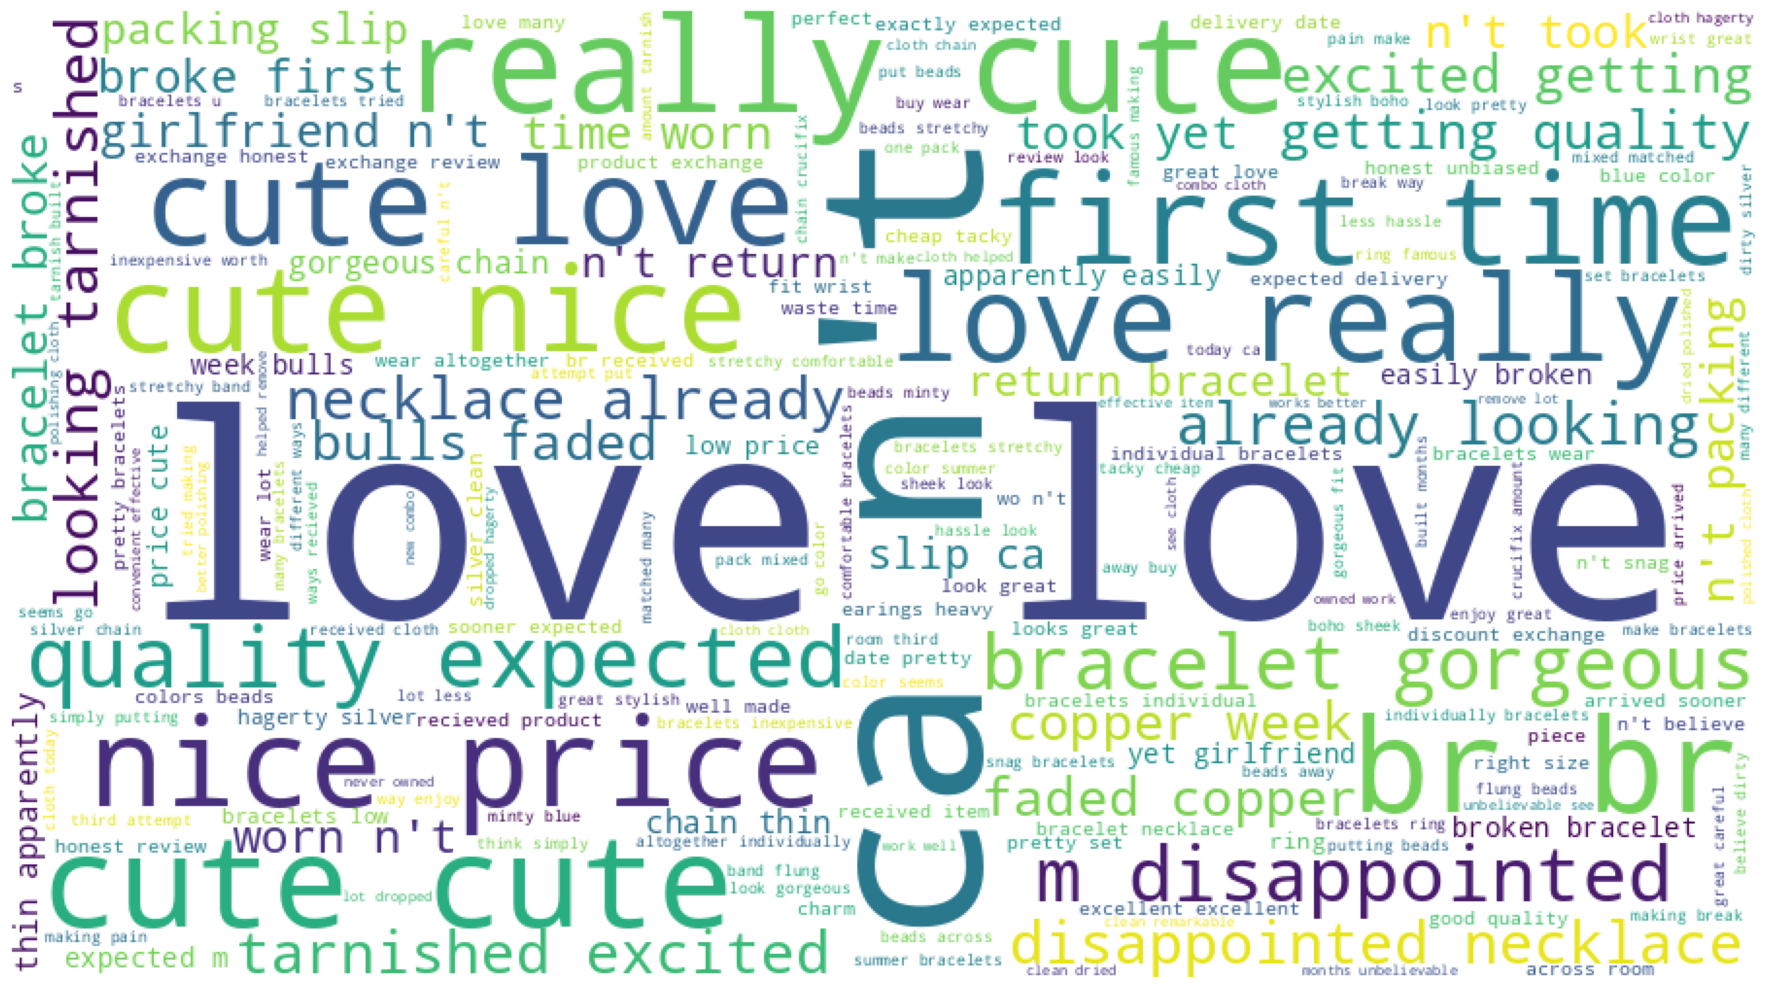

In [70]:
plot_wordCloud(pos_wordcloud)

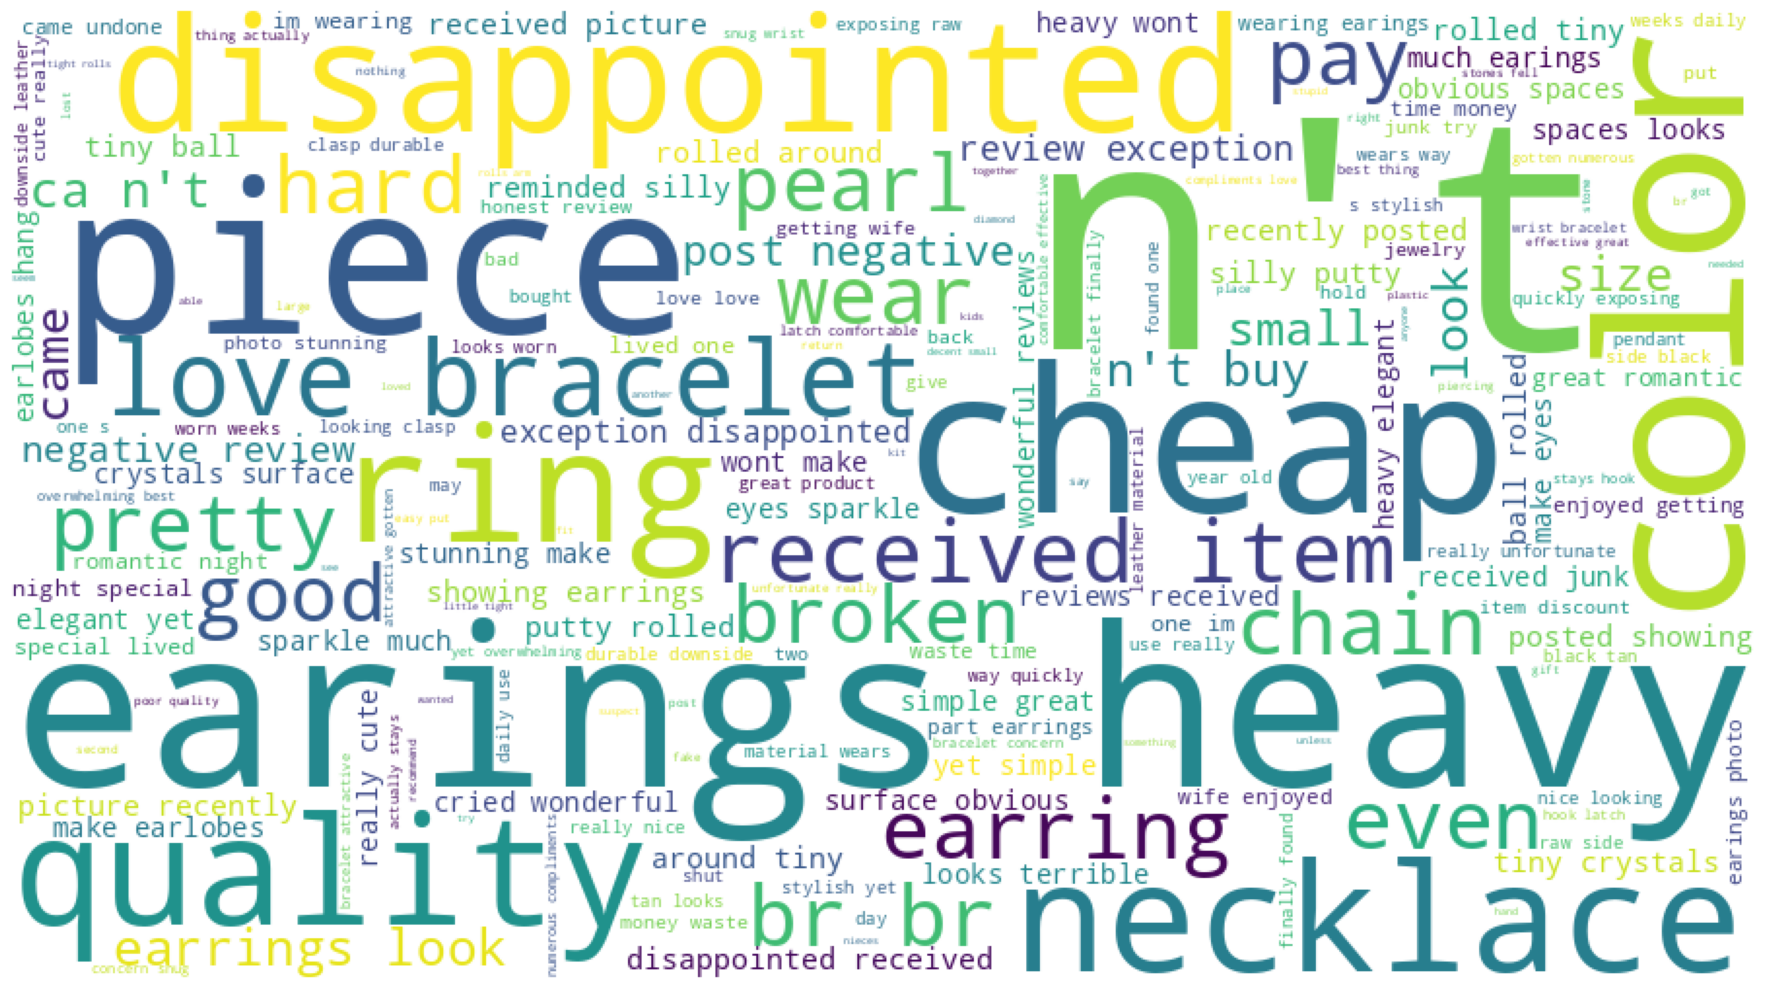

In [71]:
plot_wordCloud(neg_wordcloud)

###Sentiment distribution across each product along with star ratings  

Displays star ratings and sentiments side by side for products to see if and how they correlate - might be useful for businesses to understand customer's views

In [72]:
#total number of postive,negative and null reviews for all the products
new_df = new_analysis_df.groupby("product_id","sent_score","star_rating").count()
#transposes sent_score from row to column
new_df.groupBy("product_id","star_rating").pivot("sent_score").count().show()

+----------+-----------+----+----+----+
|product_id|star_rating| neg| neu| pos|
+----------+-----------+----+----+----+
|B00ESNWYR2|          5|NULL|NULL|   1|
|B005LD5H8Q|          3|NULL|   1|NULL|
|B00M9AD006|          4|NULL|   1|NULL|
|B007RNE6JO|          4|NULL|NULL|   1|
|B00CC88ND4|          5|NULL|NULL|   1|
|B00FPBANRY|          1|NULL|   1|   1|
|B007A3KQ6I|          1|NULL|   1|NULL|
|B00DN6XI7A|          5|NULL|NULL|   1|
|B0084PEYXM|          3|NULL|NULL|   1|
|B00JXB9A3K|          2|   1|NULL|NULL|
|B00MFX4RV8|          5|NULL|NULL|   1|
|B00DZG115O|          4|NULL|NULL|   1|
|B00JUR18VE|          5|NULL|NULL|   1|
|B00EEJEUSQ|          5|NULL|NULL|   1|
|B00DBF36YI|          4|NULL|   1|NULL|
|B00S7S7LN6|          2|NULL|   1|NULL|
|B00MTBYKHM|          5|NULL|NULL|   1|
|B00E41EVJM|          5|NULL|NULL|   1|
|B00AAJT40I|          5|NULL|NULL|   1|
|B009CPE5MI|          5|NULL|NULL|   1|
+----------+-----------+----+----+----+
only showing top 20 rows



### Comparison of sentiments with ratings

Shows the number of sentiment review's the analyser was able to predict accurately by comparing with user given ratings

In [73]:
# select all reviews in the top 10000 records that are 5 stars and are positively rated
pos_df = new_analysis_df.filter("sent_score='pos'")
readings = spark.createDataFrame(pos_df.take(10000)).filter("star_rating >= 5")

# select all reviews in the top 10000 records that are 3 stars and are neutrally rated
neu_df = new_analysis_df.filter("sent_score='neu'")
readings2 = spark.createDataFrame(neu_df.take(10000)).filter("star_rating = 3")


# select all reviews in the top 10000 records that are less than 2 stars and are negatively rated
neg_df = new_analysis_df.filter("sent_score='neg'")
readings3 = spark.createDataFrame(neg_df.take(10000)).filter("star_rating <= 2")

print("Positive sentiments with 5 star rating for the first 10000 records are %d." % readings.count())
print("Neutral sentinments at 3 star rating for the first 10000 records are %d." % readings2.count())
print("Negative sentiments with less than 2 stars for the first 10000 records are %d." % readings3.count())




Positive sentiments with 5 star rating for the first 10000 records are 3798.
Neutral sentinments at 3 star rating for the first 10000 records are 403.
Negative sentiments with less than 2 stars for the first 10000 records are 93.
